In [1]:
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tensorflow as tf
import tensorlayer as tl
import matplotlib.pyplot as plt
import os


# import our model and env
from env import PortfolioEnv
from mcpg import mcpg_actor, mcpg_actor_cs

In [2]:
pd.show_versions()

C:\Users\lee\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



INSTALLED VERSIONS
------------------
commit           : 91111fd99898d9dcaa6bf6bedb662db4108da6e6
python           : 3.8.3.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : Chinese (Simplified)_China.936

pandas           : 1.5.1
numpy            : 1.21.5
pytz             : 2022.1
dateutil         : 2.8.2
setuptools       : 65.5.0
pip              : 22.2.2
Cython           : 0.29.32
pytest           : 7.1.2
hypothesis       : None
sphinx           : 5.0.2
blosc            : None
feather          : None
xlsxwriter       : 3.0.3
lxml.etree       : 4.9.1
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.6.0
pandas_datareader: 0.10.0
bs4              : 4.11.1
bottleneck       : 

[*********************100%***********************]  10 of 10 completed


<AxesSubplot:xlabel='Date'>

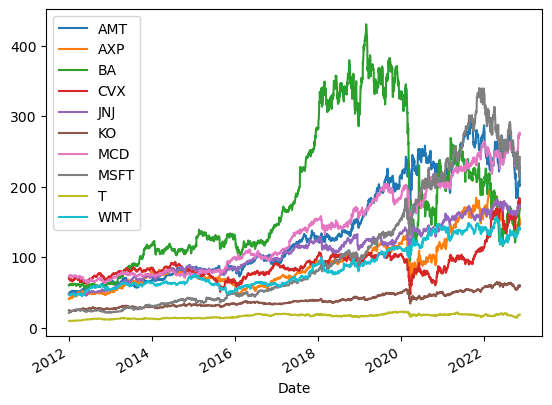

In [3]:
import yfinance as yf

stocks =  ['amt', 'axp', 'ba', 'cvx', 'jnj', 'ko', 'mcd', 'msft', 't', 'wmt']
start = datetime(2012,1,1)
end = datetime(2022,11,11)
data = yf.download(stocks, start=start, end=end)
data_close = data['Adj Close']
data_close.plot()

In [4]:
df = data.drop('Close', axis=1)
df = df[['Open','High','Low','Adj Close','Volume']]
df.columns = df.columns.swaplevel(0, 1)
df.sort_index(axis=1, level=0, inplace=True)
df.columns = pd.MultiIndex.from_product([stocks,['open', 'high', 'low', 'close', "volume"]], 
                                        names=['stock', 'price'])
df = df.dropna()

start = datetime.strptime("2012-02-01", '%Y-%m-%d' )
df_ = df.loc[start:]

# set the env input
history = df_ # the stock data
abbreviation = stocks # name of stock
steps = 200 # step for one eps
trading_cost = 0.0025
time_cost = 0.00 # cost of holding equity
window_length = 10 # for obs
eps_move = 0 # move the start date after each rest
sample_start_date = "2018-05-01"


# build the actor, critic, and target network 
gamma = 1 # discount factor
state_shape = [None,len(abbreviation),window_length,5] # (none, m_stock, history_window, feature)
action_shape = [None,len(abbreviation)] # (none, m_stock)
a_learning_rate = 0.001 # learning rate for actor

In [ ]:
data_close['2013-06-01':'2013-09-01'].plot()

# general Test

In [ ]:
import matplotlib.pyplot as plt
import os

# build out agents
#  gamma, state_shape, action_shape, a_learning_rate, target_lr, c_learning_rate
a = mcpg_actor.Actor_NetWork(gamma, state_shape,action_shape,a_learning_rate)

RANDOM_SEED = 1234

# build the env
PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, steps, trading_cost,\
                                   time_cost, window_length, eps_move, sample_start_date,\
                                   0, 0.05 ,0
                                  )
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

state_dim = PM_env.observation_space.shape
action_dim = PM_env.action_space.shape
action_range = PM_env.action_space.high  # scale action, [-action_range, action_range]

TRAIN_EPISODES = 100

train = True
RENDER = False

ALG_NAME = "MCPG"
ENV_ID = "Portfolio_Env"

t0 = time.time()
if train:  # train
    all_episode_reward = []
    for episode in range(TRAIN_EPISODES):
        state_trajectory = []
        reward_trajectory = []
        state, info = PM_env.reset() 
        episode_reward = 0
        # Sample a trajectory
        for step in range(steps):
            #print(state)
            if RENDER:
                PM_env.render()
            # Add exploration noise
            state_trajectory.append(state)
            action = a.Generate_action(state, greedy = True) #[[a0, a1, a2]]
            
            #print(action)
            state_, reward, done, info = PM_env.step(action) # compute the immidate reward and move to next steps
            #print(info)

            state = state_
            reward_trajectory.append(reward * gamma**step)
            episode_reward += reward * gamma**step
            if done:
                break
                
        # update the actor network
        G = np.cumsum(reward_trajectory[::-1])[::-1] # compute the G_t
        for step in range(steps):
            Gt = G[step] 
            St = state_trajectory[step]
            a.learn(St, Gt)
        if episode == 0:
            all_episode_reward.append(episode_reward)
        else:
            all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
        print(
            'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TRAIN_EPISODES, episode_reward,
                time.time() - t0
            )
        )
    a.save()
    plt.plot(all_episode_reward)
    if not os.path.exists('image'):
        os.makedirs('image')
    plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))
    
    
    
# Test our model

test = True
TEST_EPISODES = 1
TEST_steps = steps


# right after the end of train data
#test_start_date = str(history.loc[sample_start_date:].index[steps])
#test_start_date= test_start_date[0:10] # only need year-month-day
test_start_date = sample_start_date

eps_move =  0# 
PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, steps, trading_cost,\
                                   time_cost, window_length, eps_move, sample_start_date,\
                                   0, 0.05 ,0
                                  )
weight_track = {}
for name in abbreviation:
    weight_track[name] = []
    

if test:
    # test
    a.load() # load previous parameters
    win_case = [] #used to count when cnn_model beat the equal weight portfolio
    for episode in range(TEST_EPISODES):
        state, info = PM_env.reset()
        episode_reward = 0
        for step in range(TEST_steps):
            action = a.Generate_action(state, greedy = True)
            state, reward, done, info = PM_env.step(action)
            #print(info)
            for i in range(len(abbreviation)):
                name = abbreviation[i]
                weight_track[name].append(action[0][i])
            episode_reward += reward * gamma**step
            if done:
                break
        if PM_env.infos[-1]["portfolio_value"] > PM_env.infos[-1]["equal_weight_portfolio_value"]:
            win_case.append(1) # if the CNN portfolio win
        else:
            win_case.append(0)
        PM_env.render()
        print(
            'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TEST_EPISODES, episode_reward,
                time.time() - t0
            )
        )


In [ ]:
# the weight plot



x = np.arange(0,steps,1)
for name in abbreviation:
    y = weight_track[name]
    plt.plot(x, y, label = name, linestyle="-.")   
plt.legend()
plt.show()

# Forward Stepping Test

[TL] Input  _inputlayer_1: [None, 10, 10, 5]
[TL] Conv2d conv1: n_filter: 5 filter_size: (1, 1) strides: (1, 1) pad: VALID act: relu
[TL] Conv2d conv2: n_filter: 5 filter_size: (1, 10) strides: (1, 1) pad: VALID act: relu
[TL] MaxPool2d pool1: filter_size: (3, 3) strides: (2, 2) padding: SAME
[TL] Flatten flatten:
[TL] Dense  output: 10 softmax_v2
[TL] [*] Saving TL weights into model\MCPG_PM\actor.hdf5
[TL] [*] Saved
[TL] [*] Load model\MCPG_PM\actor.hdf5 SUCCESS!
Testing  | Episode: 1/7 | Episode Reward: -0.0012  | Running Time: 6.5472
[TL] [*] Saving TL weights into model\MCPG_PM\actor.hdf5
[TL] [*] Saved
[TL] [*] Load model\MCPG_PM\actor.hdf5 SUCCESS!
Testing  | Episode: 2/7 | Episode Reward: 0.0014  | Running Time: 7.3887
[TL] [*] Saving TL weights into model\MCPG_PM\actor.hdf5
[TL] [*] Saved
[TL] [*] Load model\MCPG_PM\actor.hdf5 SUCCESS!
Testing  | Episode: 3/7 | Episode Reward: 0.0012  | Running Time: 8.2336
[TL] [*] Saving TL weights into model\MCPG_PM\actor.hdf5
[TL] [*] Save

<Figure size 640x480 with 0 Axes>

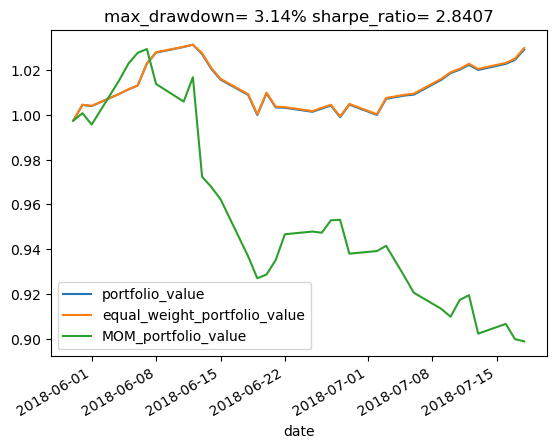

In [5]:
# Forward Stepping Test

TRAIN_EPISODES = 55

alpha = 0.9
beta = 0
gamma_ = 0

train = True
RENDER = False

ALG_NAME = "MCPG"
ENV_ID = "Portfolio_Env"

eps_move = 5

# trainning env
PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, steps, trading_cost,\
                                   time_cost, window_length, eps_move, sample_start_date,\
                                   alpha, beta ,gamma_
                                  )

# build the model
a =  mcpg_actor.Actor_NetWork(gamma, state_shape,action_shape,a_learning_rate)

test = True
TEST_EPISODES = TRAIN_EPISODES
TEST_step = eps_move # after the model is trained, n steps to test the data
TEST_steps = TEST_step * TEST_EPISODES # total steps for test period


# right after the end of train data
test_start_date = str(history.loc[sample_start_date:].index[steps])
test_start_date= test_start_date[0:10] # only need year-month-day

# test env
test_PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, TEST_steps, trading_cost,\
                                   time_cost, window_length, eps_move, test_start_date,\
                                    alpha, beta ,gamma_
                                  )

weight_track = {}
weighted_rank = []
for name in abbreviation:
    weight_track[name] = []

t0 = time.time()
if train:  # train
    test_state, test_info = test_PM_env.reset()
    for episode in range(TRAIN_EPISODES):
        state_trajectory = []
        reward_trajectory = []
        ###################################### Train the model ############################################
        state, info = PM_env.reset()
        episode_reward = 0
        for step in range(steps):
            #print(state)
            if RENDER:
                PM_env.render()
            # Add exploration noise
            state_trajectory.append(state) # 0,1, ..., T-1
            action = a.Generate_action(state, greedy = True) #[[a0, a1, a2]]
            
            #print(action)
            state_, reward, done, info = PM_env.step(action) # compute the immidate reward and move to next steps
            #print(info)

            state = state_
            reward_trajectory.append(reward * gamma**step)
            episode_reward += reward * gamma**step
            if done:
                break
                
        # update the actor network
        G = np.cumsum(reward_trajectory[::-1])[::-1] # compute the G_t
        for step in range(steps):
            Gt = G[step] 
            St = state_trajectory[step]
            a.learn(St, Gt)
        a.save()
        ###################################### Test the model ############################################
        # test
        a.load() # load previous parameters
        for step in range(TEST_step):
            test_action = a.Generate_action(test_state, greedy = True)
            test_state, reward, done, info = test_PM_env.step(test_action)
            for i in range(len(abbreviation)):
                name = abbreviation[i]
                weight_track[name].append(test_action[0][i])
            weighted_rank.append(test_PM_env.sim.weighted_rank)
            if done:
                break
        print(
            'Testing  | Episode: {}/{} | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TRAIN_EPISODES, 
                episode_reward,
                time.time() - t0
            )
        )
test_PM_env.render()       
a.save()

In [ ]:
len(reward_trajectory)

In [ ]:
# the weight plot, show the dynamic of portfolio

import matplotlib.pyplot as plt
import numpy as np


x = test_PM_env.date_track[0:TEST_steps]
for name in abbreviation:
    y = weight_track[name]
    plt.plot(x, y, label = name, linestyle="-.")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Weight")
#plt.ylim(0.0975, 0.1025)
plt.legend(loc = 'upper right')
plt.title("DPG Dynamic weight")
plt.show()

plt.plot(x, weighted_rank,  linestyle="-")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Weighted Rank")
y = len(abbreviation) * (len(abbreviation) - 1)/ (2 * len(abbreviation))
plt.axhline(y = y, color = 'r', linestyle = '-')
#plt.legend(loc = 'upper right')
plt.title("Weighted Rank ")
plt.show()

In [ ]:
test_PM_env.table()

# Forward Stepping Test CS

In [ ]:
# Forward Stepping Test

TRAIN_EPISODES = 55

alpha = 0.9
beta = 0
gamma_ = 0

train = True
RENDER = False

ALG_NAME = "MCPG_TS"
ENV_ID = "Portfolio_Env"

eps_move = 5

# trainning env
PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, steps, trading_cost,\
                                   time_cost, window_length, eps_move, sample_start_date,\
                                   alpha, beta ,gamma_
                                  )

# build the model
a =  mcpg_actor_cs.Actor_NetWork(gamma, state_shape,action_shape,a_learning_rate)

test = True
TEST_EPISODES = TRAIN_EPISODES
TEST_step = eps_move # after the model is trained, n steps to test the data
TEST_steps = TEST_step * TEST_EPISODES # total steps for test period


# right after the end of train data
test_start_date = str(history.loc[sample_start_date:].index[steps])
test_start_date= test_start_date[0:10] # only need year-month-day

# test env
test_PM_env = PortfolioEnv.PortfolioEnv(history, abbreviation, TEST_steps, trading_cost,\
                                   time_cost, window_length, eps_move, test_start_date,\
                                    alpha, beta ,gamma_
                                  )

weight_track = {}
weighted_rank = []
for name in abbreviation:
    weight_track[name] = []

t0 = time.time()
if train:  # train
    test_state, test_info = test_PM_env.reset()
    for episode in range(TRAIN_EPISODES):
        state_trajectory = []
        reward_trajectory = []
        ###################################### Train the model ############################################
        state, info = PM_env.reset()
        episode_reward = 0
        for step in range(steps):
            #print(state)
            if RENDER:
                PM_env.render()
            # Add exploration noise
            state_trajectory.append(state)
            action = a.Generate_action(state, greedy = True) #[[a0, a1, a2]]
            
            #print(action)
            state_, reward, done, info = PM_env.step(action) # compute the immidate reward and move to next steps
            #print(info)

            state = state_
            reward_trajectory.append(reward * gamma**step)
            episode_reward += reward * gamma**step
            if done:
                break
                
        # update the actor network
        G = np.cumsum(reward_trajectory[::-1])[::-1] # compute the G_t
        for step in range(steps):
            Gt = G[step] 
            St = state_trajectory[step]
            a.learn(St, Gt)
        a.save()
        ###################################### Test the model ############################################
        # test
        a.load() # load previous parameters
        for step in range(TEST_step):
            test_action = a.Generate_action(test_state, greedy = True)
            test_state, reward, done, info = test_PM_env.step(test_action)
            for i in range(len(abbreviation)):
                name = abbreviation[i]
                weight_track[name].append(test_action[0][i])
            weighted_rank.append(test_PM_env.sim.weighted_rank)
            if done:
                break
        print(
            'Testing  | Episode: {}/{} | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                episode + 1, TRAIN_EPISODES, 
                episode_reward,
                time.time() - t0
            )
        )
test_PM_env.render()       
a.save()

In [ ]:
# the weight plot, show the dynamic of portfolio

import matplotlib.pyplot as plt
import numpy as np


x = test_PM_env.date_track[0:TEST_steps]
for name in abbreviation:
    y = weight_track[name]
    plt.plot(x, y, label = name, linestyle="-.")

plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Weight")
#plt.ylim([0, 1])
plt.legend(loc = 'upper right')
plt.title("DPG Dynamic weight")
plt.show()

plt.plot(x, weighted_rank,  linestyle="-")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Weighted Rank")
#plt.ylim([0, 9])
y = len(abbreviation) * (len(abbreviation) - 1)/ (2 * len(abbreviation))
plt.axhline(y = y, color = 'r', linestyle = '-')
#plt.legend(loc = 'upper right')
plt.title("Weighted Rank ")
plt.show()

In [ ]:
test_PM_env.table()